# Volatility Modelling in Python

This tutorial demonstrates the use of Python tools and libraries applied to volatility modelling, more specifically the generalized autoregressive conditional heteroscedasticity (GARCH) model.

Working with financial data, we are often faced with processing time series, that is sequences of discrete time data (e.g. the daily closing value of a stock market index). To work with such data, we often use parametric models in the time-domain.

A GARCH model is essentially an autoregressive conditional heteroskedasticity model for which an autoregressive moving average model (ARMA model) is assumed for the error variance.

## Getting the data

The first step of our tutorial is to get the data. For this tutorial, we will use the adjusted closing price of 10 stocks (the adjustment is done to account for the dividends and the splits).

The pandas_datareader library could prove useful for this task (note that such tools are very sensitive to changes in the target API). However, this will be the subject of some other tutorial. For now, let's just read the local files.

In [1]:
import pandas as pd
import string

raw_prices = pd.DataFrame(columns=['Date'])
stock_names = string.ascii_uppercase[:10]

for stock_name in stock_names:
    raw_data = pd.read_csv('data/'+stock_name+'.csv')[['Date','Adj Close']]
    raw_data.rename(columns={'Adj Close':stock_name},inplace=True)
    raw_data.dropna(inplace=True)
    raw_prices = pd.merge(raw_prices,raw_data,how='outer',on='Date')
    
raw_prices.sort_values(by='Date',inplace=True)
raw_prices.head()

,Date,A,B,C,D,E,F,G,H,I,J
8450,1962-01-02,NaN,0.202636,NaN,0.059620,NaN,NaN,NaN,NaN,NaN,NaN
8451,1962-01-03,NaN,0.206688,NaN,0.060421,NaN,NaN,NaN,NaN,NaN,NaN
8452,1962-01-04,NaN,0.204662,NaN,0.060421,NaN,NaN,NaN,NaN,NaN,NaN
8453,1962-01-05,NaN,0.200609,NaN,0.060621,NaN,NaN,NaN,NaN,NaN,NaN
8454,1962-01-08,NaN,0.201116,NaN,0.060421,NaN,NaN,NaN,NaN,NaN,NaN


We can see that some of the assets had prices back in the 60's but that many didn't. Let's keep dates for which we have data for every stock. We could also have done inner joins, but, first, we wanted to show the complete picture. (We leave it to the reader as an exercise do write inner joins.)

In [2]:
raw_prices.dropna(inplace=True)
raw_prices.head()

,Date,A,B,C,D,E,F,G,H,I,J
1550,1990-02-16,3.657441,12.040095,0.064382,6.770798,4.859589,0.456696,3.713418,1.243683,0.841391,3.756277
1551,1990-02-20,3.556310,11.776785,0.066552,6.647411,4.784537,0.467182,3.615980,1.222314,0.815098,3.688598
1552,1990-02-21,3.539457,11.585296,0.065105,6.593432,4.690724,0.447959,3.605154,1.260778,0.817727,3.637836
1553,1990-02-22,3.488895,11.609239,0.065829,6.562585,4.690724,0.449124,3.551025,1.291745,0.815098,3.595536
1554,1990-02-23,3.438330,11.489553,0.065467,6.462332,4.615672,0.454366,3.518545,1.253250,0.809839,3.527858


In [3]:
raw_prices.tail()

,Date,A,B,C,D,E,F,G,H,I,J
8444,2017-06-28,89.328644,199.619995,31.783060,106.070923,154.300003,69.800003,76.510002,153.229996,34.200001,133.820007
8445,2017-06-29,90.651367,197.460007,31.119259,104.929413,153.130005,68.489998,75.930000,152.160004,33.540001,132.639999
8446,2017-06-30,90.900002,197.750000,31.010277,105.465424,153.160004,68.930000,75.680000,153.399994,33.740002,132.289993
8447,2017-07-03,92.750000,198.589996,31.039999,106.666489,152.500000,68.169998,75.360001,154.009995,33.459999,132.899994
8449,2017-07-06,93.379997,201.479996,30.719999,103.349998,153.089996,68.570000,75.470001,152.050003,33.630001,132.520004


This seems better. Let's constrain our analysis from Mar 1, 1990, to Jun 31, 2017, in order to have complete calendar year quarters. (We leave as an exercise to the reader to make sure that we have data for every trading day in that period.)

In [4]:
raw_prices = raw_prices[(raw_prices.Date>'1990-03') & (raw_prices.Date<'2017-07')]
raw_prices.head(2)

,Date,A,B,C,D,E,F,G,H,I,J
1558,1990-03-01,3.43833,12.447020,0.066552,6.670546,4.739837,0.466017,3.864985,1.364459,0.854538,3.654757
1559,1990-03-02,3.50575,12.423082,0.067275,6.732243,4.777454,0.483492,3.908290,1.364459,0.857166,3.722438


In [5]:
raw_prices.tail(2)

,Date,A,B,C,D,E,F,G,H,I,J
8445,2017-06-29,90.651367,197.460007,31.119259,104.929413,153.130005,68.489998,75.93,152.160004,33.540001,132.639999
8446,2017-06-30,90.900002,197.750000,31.010277,105.465424,153.160004,68.930000,75.68,153.399994,33.740002,132.289993


For simplicity, let's pretend that our portfolio consists of one share of each stock.

In [6]:
raw_prices['Close'] = raw_prices[list(stock_names)].sum(axis=1)
portfolio = raw_prices.reset_index()[['Date','Close']].copy()
portfolio.head()

,Date,Close
0,1990-03-01,37.567041
1,1990-03-02,37.841649
2,1990-03-05,37.961847
3,1990-03-06,38.351505
4,1990-03-07,38.399774


## Plotting the data

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


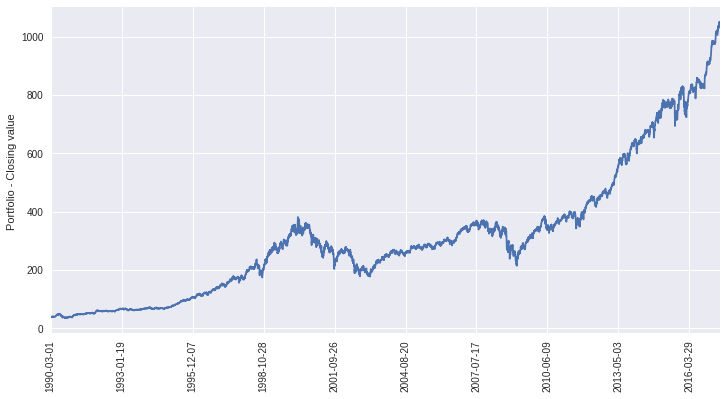

In [8]:
f, ax = plt.subplots(figsize=(12, 6))
sns.set(color_codes=True)
sns.tsplot(data=portfolio.Close, ax=ax)

xticks = range(0,len(portfolio),365*2)
ax.set_xticks(xticks)
ax.set_xticklabels([pd.to_datetime(portfolio.Date).dt.date[i] for i in xticks], rotation=90)
ax.set_ylabel('Portfolio - Closing value ')


## Computing returns and squared returns

In [9]:
portfolio['Return'] = np.log(portfolio.Close / portfolio.Close.shift())
portfolio['R2'] = np.square(portfolio['Return'])
portfolio.tail()

,Date,Close,Return,R2
6884,2017-06-26,1045.294773,-0.001264,0.000002
6885,2017-06-27,1042.395983,-0.002777,0.000008
6886,2017-06-28,1048.662634,0.005994,0.000036
6887,2017-06-29,1040.050053,-0.008247,0.000068
6888,2017-06-30,1042.325696,0.002186,0.000005


Note that we use the daily continuously compounded return (log return) instead of the daily simple rate of return as given by the pct_change method:

In [10]:
portfolio.Close.pct_change().tail()

6884   -0.001263
6885   -0.002773
6886    0.006012
6887   -0.008213
6888    0.002188
Name: Close, dtype: float64

Both returns appear relatively similar. However, they both have their pros and cons. The main reason we prefer to use the log return is that we can calculate the compounded return over a specific horizon by adding the daily returns. This simple fact facilitates the development of models.


## Autocorrelation

The autocorrelation is the correlation of a series with a delayed, or shifted, copy of itself. It is a useful tool for detecting linear dynamics in time series analysis.

Let's look at the autocorrelation of daily returns.

In [11]:
def plot_autocorrelation(returns, y_label,zero_line=False):
    lags = np.arange(1,101)
    return_autocorr = [returns.autocorr(lag=lag) for lag in lags]

    f, ax = plt.subplots(figsize=(12, 6))
    sns.set(color_codes=True)
    sns.tsplot(data=return_autocorr, time=lags, ax=ax)
    ax.set_xticks(np.arange(lags[0]-1,lags[-1]+1,10))
    ax.set_xlabel('Lag order')
    ax.set_ylabel(y_label)
    if(zero_line):
        plt.plot([lags[0],lags[-1]], [0,0], 'b')

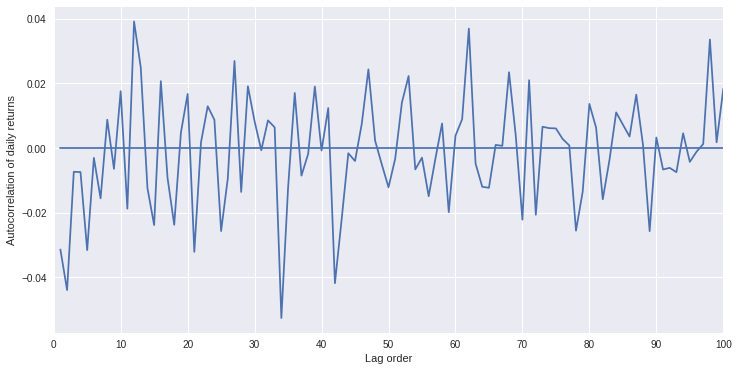

In [12]:
plot_autocorrelation(portfolio.Return, 'Autocorrelation of daily returns',zero_line=True)

We see that there is very little autocorrelation for daily returns of the S&P 500 over this period. Let's look at the autocorrelation of the squared returns.

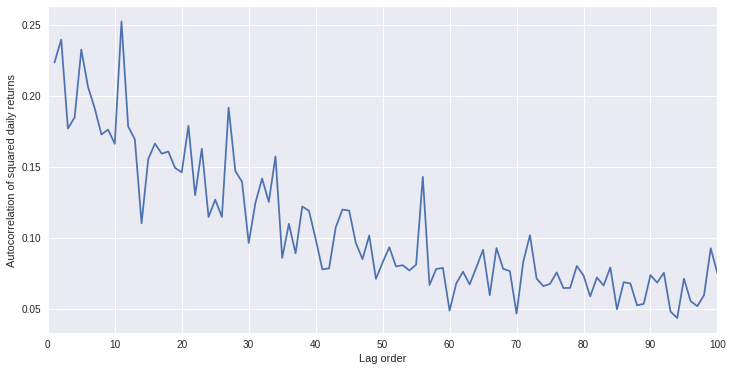

In [13]:
plot_autocorrelation(portfolio.R2, 'Autocorrelation of squared daily returns')

We notice a fair amount of autocorrelation of the squared returns.

## GARCH(1,1)

For the purpose of this tutorial, let's first build our own model. In this model, we consider one lag of returns squared and one lag of variance (1,1).

In [14]:
import scipy.optimize as opt

def compute_omega(factor,alpha,beta):
    persistence = alpha + beta
    return factor *(1-persistence)        
    
def compute_cond_var(data,initial_value,alpha,beta,omega=None):
    if omega is None:
        omega = compute_omega(initial_value,alpha,beta)
    cond_var = np.array([initial_value], dtype=np.float64)
    for time in range(1,len(data)):
        cond_var = np.append(cond_var,(omega +beta*cond_var[time-1]+alpha*data[time]**2))
    return cond_var

In [15]:
def fn(x, df, r_var):
    sig_2 = compute_cond_var(df.Return,r_var,x[0],x[1])[:-1]
    return (np.log(sig_2)+df.R2[1:]/sig_2).sum()*1/2

res = opt.minimize(fn, [0.08,0.82], bounds=[[0,1],[0,1]], 
                    args=(portfolio, portfolio.Return.std()**2))
res

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


      fun: -28107.387398143728
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.11132215,  0.08949428])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 10
   status: 0
  success: True
        x: array([ 0.08210269,  0.908509  ])

In [16]:
compute_cond_var(portfolio.Return,portfolio.Return.std()**2,res.x[0],res.x[1])

array([  1.46845582e-04,   1.39144331e-04,   1.28618231e-04, ...,
         3.01296863e-05,   3.43355444e-05,   3.29649827e-05])

It turns out that a python library exists for such models. Let's use it to build a GARCH(1,1) model and compare it to our own model.

In [17]:
from arch import arch_model
garch = arch_model(100*portfolio.Return[1:],)
res = garch.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 9921.63392772
Iteration:     10,   Func. Count:     72,   Neg. LLF: 9918.29018018
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9918.28947529
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -9918.29
Distribution:                  Normal   AIC:                           19844.6
Method:            Maximum Likelihood   BIC:                           19871.9
                                        No. Observations:                 6888
Date:                Fri, Jul 07 2017   Df Residuals:                     6884
Time:                     

In [18]:
omega = res.params['omega']/(100**2)
omega

1.4177695568094985e-06

In [19]:
compute_cond_var(portfolio.Return,portfolio.Return.std()**2,res.params['alpha[1]'],res.params['beta[1]'],omega)

array([  1.46845582e-04,   1.38870052e-04,   1.27938520e-04, ...,
         3.00012610e-05,   3.44409699e-05,   3.29932817e-05])

In the next tutorial, we will use this model to forecast 24-hour return volatilities.